# Figure 4 Final

Notebook to make data for figure 4 for ms <br>
by Cascade Tuholske 2020.02.23

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
#### Functions
def OLS(df, geog, col, alpha):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography
    
    NOTE 2020.03.01 - This will throw a run time warning if all values of a col are zero (e.g. can regress
    a bunch of zeros) ... See note in run_OLD. CPT 
    
    NOTE 2020.03.01 - Later in the day this issue is resolved by removing the offending cities. See comments
    in code. CPT
    
    
    Args:
        df = HI stats dataframe
        geog = subset geography to calc people days regression
        col = col to regress on 
        alpha = ci alpha for coef
    """

    # Get results
    labels = []
    #delt_list = [] #CPT 2020.02.26
    #r2_list = [] #CPT 2020.02.26
    coef_list = []
    leftci_list = []
    rightci_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[col].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        #r2 = model.rsquared_adj #CPT 2020.02.26
        p = model.pvalues[0]

        # Pop change #CPT 2020.02.26
#         delt = df_geog.drop_duplicates('ID_HDC_G0').copy()
#         delt['delt_pop'] = delt['P2016'] - delt['P1983']
#         delt = delt['delt_pop'].sum()

        # GET Left and Right CI
        left_ci = model.conf_int(alpha=alpha)[1][0]
        right_ci = model.conf_int(alpha=alpha)[1][1]
        
        # Make lists
        labels.append(label)
        #r2_list.append(r2) #CPT 2020.02.26
        coef_list.append(coef)
        p_list.append(p)
        leftci_list.append(left_ci)
        rightci_list.append(right_ci)
        #delt_list.append(delt) #CPT 2020.02.26

    # Make data frame
    df_out[geog] = labels
    #df_out['p_delt'] = delt_list #CPT 2020.02.26
    #df_out['r2'] = r2_list #CPT 2020.02.26
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]
    df_out['ci_left'] = leftci_list
    df_out['ci_right'] = rightci_list 

    return df_out


In [ ]:
def run_OLS(stats, geog, alpha):
    """ Function calculate OLS coef of people days due to pop and heat and the 
    attribution index for distribution plots.
    
        
    NOTE 2020.03.01 - This will throw a run time warning if all values of a col are zero (e.g. can regress
    a bunch of zeros, now can we). This will happen if people_days, people_days_pop, people_days_heat or 
    total_days is zero for all years for a given city. This is still OK for our analysis. What is happening is
    that for some cities, the people-days due to heat is zero, meaning pday increases in only due to population. 
    
    This is because with the GHS-UCDB some city's population in 1983 is zero, which forces the pdays due to heat
    to be zero.
    
    NOTE 2020.03.01 - Later in the day this issue is resolved by removing the offending cities. See comments
    in code.
    
    -- CPT  
    
    Args:
        stats = df to feed in
        geog = geography level to conduct analysis (city-level is 'ID-HDC-G0')
        alpha = alpha for CI coef   
    """
    # Get coef for people days
    out = OLS(stats, geog, 'people_days', alpha = alpha)
    out.rename(columns={"coef": "coef_pdays"}, inplace = True)
    out.rename(columns={"p_value": "p_value_pdays"}, inplace = True)
    out.rename(columns={"ci_left": "ci_left_pdays"}, inplace = True)
    out.rename(columns={"ci_right": "ci_right_pdays"}, inplace = True)
    
    # Get people days due to heat coef
    heat = OLS(stats, geog, 'people_days_heat', alpha = alpha) # get stats 
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    heat.rename(columns={"p_value": "p_value_heat"}, inplace = True)
    heat.rename(columns={"ci_left": "ci_left_heat"}, inplace = True)
    heat.rename(columns={"ci_right": "ci_right_heat"}, inplace = True)
    out = out.merge(heat, on = geog, how = 'left') # merge
    
    # Get people days due to pop
    pop = OLS(stats, geog, 'people_days_pop', alpha = alpha) # get stats 
    pop.rename(columns={"coef": "coef_pop"}, inplace = True)
    pop.rename(columns={"p_value": "p_value_pop"}, inplace = True)
    pop.rename(columns={"ci_left": "ci_left_pop"}, inplace = True)
    pop.rename(columns={"ci_right": "ci_right_pop"}, inplace = True)
    out = out.merge(pop, on = geog, how = 'left') # merge
    
    # Get total days
    totDays = OLS(stats, geog, 'total_days', alpha = alpha) # get stats 
    totDays.rename(columns={"coef": "coef_totDays"}, inplace = True)
    totDays.rename(columns={"p_value": "p_value_totDays"}, inplace = True)
    totDays.rename(columns={"ci_left": "ci_left_totDays"}, inplace = True)
    totDays.rename(columns={"ci_right": "ci_right_totDays"}, inplace = True)
    out = out.merge(totDays, on = geog, how = 'left') # merge
    
    # attrib coef --- creates range -1 to 1 index of heat vs. population as a driver of total pdays increase
    out['coef_attrib'] = (out['coef_pop'] - out['coef_heat']) / (out['coef_pop'] + out['coef_heat']) # normalize dif
    
    # I am not sure if this works correcetly ... CPT 2020.02.27
    out['coef_attrib_left'] = (out['ci_left_pop'] - out['ci_left_heat']) / (out['ci_left_pop'] + out['ci_left_heat']) # normalize dif
    out['coef_attrib_right'] = (out['ci_right_pop'] - out['ci_right_heat']) / (out['ci_right_pop'] + out['ci_left_heat']) # normalize dif
    
    # drop all neg or zero pday slopes
    out = out[out['coef_pdays'] > 0]
    out = out[out['coef_heat'] > 0]
    out = out[out['coef_pop'] > 0]
    
    # normalize coef of attribution 
    norm = out['coef_attrib']
    out['coef_attrib_norm'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_left']
    out['coef_attrib_norm_left'] = (norm-min(norm))/(max(norm)-min(norm))
    norm = out['coef_attrib_right']
    out['coef_attrib_norm_right'] = (norm-min(norm))/(max(norm)-min(norm))
    
    return out

In [59]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col, scale):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1]*scale)
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [3]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_IN = 'processed/All_data_HI406_figdata.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)
FN_OUT = 'processed/All_data_HI406_figdata_map.csv'

# scale the date in the plot 
scale = 10**9 

In [4]:
#### Drop 40 cities where P1983 == 40
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city IDS
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

392972
391612
391408


In [6]:
HI_STATS.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0
1,1,26,1983,1,194088.886834,194088.886834,268055.635628,0.000194,0.000194,0.0
2,2,27,1983,1,80540.779940,80540.779940,93335.494324,0.000081,0.000081,0.0
3,3,28,1983,9,59320.971209,59320.971209,91449.606255,0.000534,0.000534,0.0
4,4,29,1983,8,336518.836621,336518.836621,533318.453653,0.002692,0.002692,0.0


In [7]:
## Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/All_data_HI406_meta.csv'
all_data = pd.read_csv(DATA_IN+meta_fn)
meta = all_data[geog]
meta = meta.drop_duplicates('ID_HDC_G0')

## Merge in meta
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'left')

In [39]:
#### Select a Country

country = 'India'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
#data = HI_STATS[HI_STATS['ID_HDC_G0'] == 6334]

In [40]:
X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']

In [41]:
data.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop,region,intermediate-region,sub-region,CTR_MN_NM,GCPNT_LAT,GCPNT_LON
3904,3929,6334,1983,128,24920.674674,24920.674674,50522.148926,0.003190,0.003190,0.0,Asia,Southern Asia,Southern Asia,India,23.439135,68.716725
3932,3957,6364,1983,149,28541.426888,28541.426888,55516.997803,0.004253,0.004253,0.0,Asia,Southern Asia,Southern Asia,India,23.348603,69.269673
3933,3958,6365,1983,3,53561.495842,53561.495842,145998.342850,0.000161,0.000161,0.0,Asia,Southern Asia,Southern Asia,India,34.494095,74.135510
3937,3962,6369,1983,41,57244.504678,57244.504678,91874.101562,0.002347,0.002347,0.0,Asia,Southern Asia,Southern Asia,India,22.412880,69.018451
3939,3964,6371,1983,36,37516.297892,37516.297892,50012.630005,0.001351,0.001351,0.0,Asia,Southern Asia,Southern Asia,India,22.244177,68.968158


Text(0, 0.5, 'Days/yr HI > 40.6')

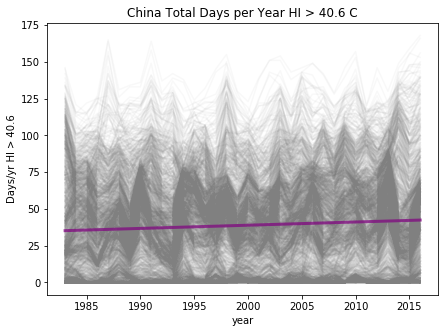

In [161]:
#### Select a Country
country = 'China'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

fig, axs = plt.subplots(1, 1, figsize = (7, 5), sharex=True)
line_kws = {'linestyle' : '-', 'linewidth' : 3, 'alpha' : 0.7}


for label, city in data.groupby('ID_HDC_G0'):
    X = city.sort_values('year')['year']
    Y = city.sort_values('year')['total_days']
    
    # set alphas 
    
    plt.plot(X,Y, alpha = 0.05, color = 'gray') #'lavender')

X = data.sort_values('year')['year']
Y = data.sort_values('year')['total_days']
sns.regplot(X, Y, color = 'purple', scatter = False, truncate = True, line_kws = line_kws)

#### Select a Country
# country = 'Indonesia'
# data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
# X = data.sort_values('year')['year']
# Y = data.sort_values('year')['total_days']

# for label, city in data.groupby('ID_HDC_G0'):
#     X = city.sort_values('year')['year']
#     Y = city.sort_values('year')['total_days']
    
#     plt.plot(X,Y, alpha = 0.05, color = 'palegreen')
    
# X = data.sort_values('year')['year']
# Y = data.sort_values('year')['total_days']
# sns.regplot(X, Y, color = 'darkgreen', scatter = False, truncate = True, line_kws = line_kws, label = 'Egypt')
    
#plt.ylim([0,25])#### Select a Country
plt.title(country+' Total Days per Year HI > 40.6 C')
plt.ylabel('Days/yr HI > 40.6')

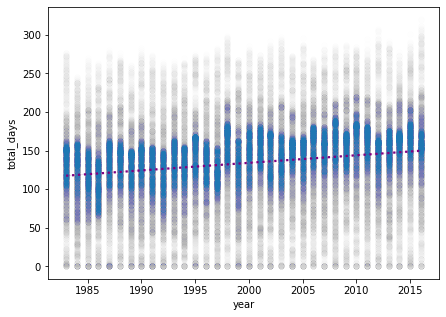

In [113]:
#### Select a Country
fig, axs = plt.subplots(1, 1, figsize = (7, 5), sharex=True)
line_kws = {'linestyle' : ':'}

country = 'India'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X = data['year']
Y = data['total_days']

plt.scatter(X,Y, alpha = 0.002)#, s = 20, marker = '.')
sns.regplot(X, Y, color = 'purple', scatter = False, truncate = True, line_kws = line_kws)
#plt.ylim([0,1])

In [19]:
len(np.unique(data['ID_HDC_G0']))

3182

# Check Total Days > 365

In [128]:
#### Select a Country
country = 'Indonesia'
data = HI_STATS[HI_STATS['CTR_MN_NM'] == country]

In [127]:
data[data['total_days']> 365]

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop,region,intermediate-region,sub-region,CTR_MN_NM,GCPNT_LAT,GCPNT_LON
145154,145699,11423,1997,531,1.622832e+05,1.365154e+05,1.519214e+05,0.086172,0.072490,0.013683,Asia,South-eastern Asia,South-eastern Asia,Indonesia,-0.316768,103.158186
145379,145924,11652,1997,401,3.473314e+04,1.699270e+04,5.132121e+04,0.013928,0.006814,0.007114,Asia,South-eastern Asia,South-eastern Asia,Indonesia,-3.203122,104.651232
145380,145925,11653,1997,405,1.988358e+06,1.834047e+06,1.910183e+06,0.805285,0.742789,0.062496,Asia,South-eastern Asia,South-eastern Asia,Indonesia,-2.967116,104.748680
145385,145930,11658,1997,371,4.816671e+04,4.000701e+04,5.046164e+04,0.017870,0.014843,0.003027,Asia,South-eastern Asia,South-eastern Asia,Indonesia,-3.258660,104.678167
145554,146099,11827,1997,450,3.452070e+04,5.304035e+03,5.929032e+04,0.015534,0.002387,0.013147,Asia,South-eastern Asia,South-eastern Asia,Indonesia,-4.564110,105.702911
329390,330589,10994,2015,491,5.173200e+04,2.480626e+04,5.173200e+04,0.025400,0.012180,0.013221,Asia,South-eastern Asia,South-eastern Asia,Indonesia,1.700530,100.403687
329453,330652,11062,2015,397,9.933963e+04,3.360183e+04,9.933963e+04,0.039438,0.013340,0.026098,Asia,South-eastern Asia,South-eastern Asia,Indonesia,2.159844,100.804734
329508,330707,11119,2015,539,1.843351e+05,1.225682e+05,1.843351e+05,0.099357,0.066064,0.033292,Asia,South-eastern Asia,South-eastern Asia,Indonesia,1.278782,101.191028
329534,330733,11146,2015,554,9.976823e+05,2.742704e+05,9.976823e+05,0.552716,0.151946,0.400770,Asia,South-eastern Asia,South-eastern Asia,Indonesia,0.506249,101.433964
329537,330736,11149,2015,515,2.331868e+05,8.191033e+04,2.331868e+05,0.120091,0.042184,0.077907,Asia,South-eastern Asia,South-eastern Asia,Indonesia,1.670196,101.446297


In [129]:
alldata = pd.read_csv(DATA_IN+'processed/All_data_HI406_meta.csv')

In [130]:
alldata.head()

,Unnamed: 0,Unnamed: 0.1,ID_HDC_G0,year,duration,avg_temp,avg_intensity,tot_intensity,event_dates,intensity,tmax,CTR_MN_NM,region,sub-region,intermediate-region,GCPNT_LAT,GCPNT_LON
0,0,0,3554,1989,1,43.438784,2.838784,2.838784,['1989.06.30'],[2.83878425],[43.43878425],Russia,Europe,Eastern Europe,Eastern Europe,64.536597,40.596246
1,1,1,3554,2003,1,41.557437,0.957437,0.957437,['2003.07.29'],[0.95743653],[41.55743653],Russia,Europe,Eastern Europe,Eastern Europe,64.536597,40.596246
2,2,2,3554,2010,1,43.966580,3.366580,3.366580,['2010.07.07'],[3.36658027],[43.96658027],Russia,Europe,Eastern Europe,Eastern Europe,64.536597,40.596246
3,3,0,9075,1984,1,43.371405,2.771405,2.771405,['1984.07.13'],[2.77140533],[43.37140533],Russia,Europe,Eastern Europe,Eastern Europe,62.054781,129.723451
4,4,1,9075,1984,1,41.317448,0.717448,0.717448,['1984.07.22'],[0.71744845],[41.31744845],Russia,Europe,Eastern Europe,Eastern Europe,62.054781,129.723451


In [136]:
list(alldata[(alldata['year'] == 1997) & (alldata['ID_HDC_G0'] == 11423)]['event_dates'])

["['1997.01.03' '1997.01.04' '1997.01.05' '1997.01.06']",
 "['1997.01.08' '1997.01.09' '1997.01.10' '1997.01.11']",
 "['1997.01.14' '1997.01.15']",
 "['1997.01.17' '1997.01.18' '1997.01.19' '1997.01.20' '1997.01.21'\n '1997.01.22' '1997.01.23' '1997.01.24' '1997.01.25' '1997.01.26'\n '1997.01.27' '1997.01.28' '1997.01.29' '1997.01.30' '1997.01.31'\n '1997.02.01' '1997.02.02']",
 "['1997.02.04']",
 "['1997.02.06' '1997.02.07' '1997.02.08' '1997.02.09' '1997.02.10']",
 "['1997.02.13' '1997.02.14' '1997.02.15' '1997.02.16' '1997.02.17'\n '1997.02.18' '1997.02.19']",
 "['1997.02.21' '1997.02.22' '1997.02.23']",
 "['1997.02.25' '1997.02.26' '1997.02.27' '1997.02.28' '1997.03.01'\n '1997.03.02' '1997.03.03' '1997.03.04' '1997.03.05' '1997.03.06'\n '1997.03.07']",
 "['1997.03.09' '1997.03.10' '1997.03.11' '1997.03.12' '1997.03.13'\n '1997.03.14' '1997.03.15' '1997.03.16' '1997.03.17' '1997.03.18']",
 "['1997.03.20' '1997.03.21' '1997.03.22' '1997.03.23' '1997.03.24'\n '1997.03.25' '1997.03.26